In [18]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensordata
sns.set_style(style='whitegrid')

datasets, features_sets, target_sets, metadata = sensordata.load_and_preprocess_data(validationset=True, savecsv=False, sensorset='FIS')
calibrationset = datasets[0]
calibration_features_matrix = features_sets[0]
calibration_co_cons = target_sets[0]
cal_experiment_matrix, cal_targets = sensordata.postprocess_data(calibration_features_matrix, calibration_co_cons)

/home/dreuter/Github/kaggle-paths/gas-sensor-array/data/gas-sensor-data.zip
already exists, file not downloaded
csv files already exists in
/home/dreuter/Github/kaggle-paths/gas-sensor-array/data,
no files extracted
Starting to import and preprocess sensor data from 20160930_203718.csv
The shape of features matrix is:
(2020, 306)
20160930_203718.csv successfully imported
Starting to import and preprocess sensor data from 20161001_231809.csv
The shape of features matrix is:
(2016, 306)
20161001_231809.csv successfully imported
Starting to import and preprocess sensor data from 20161003_085624.csv
The shape of features matrix is:
(2020, 306)
20161003_085624.csv successfully imported
Starting to import and preprocess sensor data from 20161004_104124.csv
The shape of features matrix is:
(2020, 306)
20161004_104124.csv successfully imported
Starting to import and preprocess sensor data from 20161005_140846.csv
The shape of features matrix is:
(2016, 306)
20161005_140846.csv successfully imp

## Visualization of stacked signals in feature matrix

In [2]:
cal_experiment_matrix.shape

(100, 6120)

In [3]:
pd.DataFrame(cal_experiment_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,6110,6111,6112,6113,6114,6115,6116,6117,6118,6119
0,-4.053328,-4.154434,-4.106943,-3.935907,-3.943136,-4.193959,-4.127373,-4.090106,-4.100643,-3.954253,...,-2.543073,-2.132117,-1.803820,-2.210360,-2.210360,-2.210360,-2.210360,-2.210360,-2.210360,-2.210360
1,-2.891554,-2.747527,-2.831836,-2.821278,-2.627541,-2.886152,-2.886776,-2.757558,-2.855452,-2.831936,...,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231
2,-3.170866,-3.091583,-3.118662,-3.093712,-2.917414,-3.185910,-3.177062,-3.086254,-3.135168,-3.093712,...,-2.667388,-2.296235,-1.992303,-2.357376,-2.389661,-2.172157,-2.649305,-2.276334,-1.976675,-2.346085
3,-2.991639,-2.911883,-2.933213,-2.916916,-2.724114,-2.997091,-2.999286,-2.902838,-2.959099,-2.921467,...,-3.612349,-3.403192,-3.333721,-3.614581,-3.392779,-3.441590,-3.608423,-3.403192,-3.297103,-3.563064
4,-3.817374,-3.966782,-3.876665,-3.782968,-3.751723,-3.973585,-3.840387,-3.925533,-3.894020,-3.778359,...,-2.945018,-2.637048,-2.373332,-2.681713,-2.657045,-2.527016,-2.937833,-2.617556,-2.357831,-2.670549


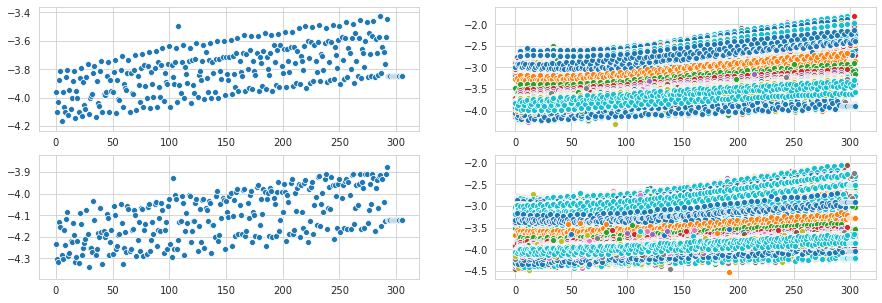

In [4]:
day = 1
fig, axes = plt.subplots(2,2, figsize=(15,5))
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[0,0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[0,1])

day = 13
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[1,0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[1,1])
plt.show()

# Random forests modelling

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

signals = cal_experiment_matrix
targets = cal_targets

X = signals
y = targets.reshape(len(targets))

test_size = 0.2
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

estimator_range = np.arange(7, 15)
max_leaf_range = np.arange(7, 15)
cv_scores_matrix = np.zeros((len(estimator_range),len(max_leaf_range)))
rmse = []

for i in estimator_range:
    for j in max_leaf_range:
        forest_reg = RandomForestRegressor(n_estimators=i, max_leaf_nodes=j, n_jobs=-1, random_state=42)
        score = model_selection.cross_val_score(forest_reg, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
        rmse.append(np.sqrt(-score))
        
        i_score = i-estimator_range[0]
        j_score = j-max_leaf_range[0]
        cv_scores_matrix[i_score, j_score] = np.sqrt(-score)
        np.savetxt('cv_score.csv',cv_scores_matrix, delimiter=',', fmt='%1.4f')
        print("Number of estimators: " + str(i) + ", number of max_leafs: " + str(j) + ", average CV score: " + str(cv_scores_matrix[i_score, j_score]))

Number of estimators: 7, number of max_leafs: 7, average CV score: 1.028804385314423
Number of estimators: 7, number of max_leafs: 8, average CV score: 1.011484858223004
Number of estimators: 7, number of max_leafs: 9, average CV score: 0.9671940916215872
Number of estimators: 7, number of max_leafs: 10, average CV score: 0.9618502842894809
Number of estimators: 7, number of max_leafs: 11, average CV score: 0.9618502842894809
Number of estimators: 7, number of max_leafs: 12, average CV score: 0.9618502842894809
Number of estimators: 7, number of max_leafs: 13, average CV score: 0.9618502842894809
Number of estimators: 7, number of max_leafs: 14, average CV score: 0.9618502842894809
Number of estimators: 8, number of max_leafs: 7, average CV score: 1.0194118236946912
Number of estimators: 8, number of max_leafs: 8, average CV score: 0.996850186903278
Number of estimators: 8, number of max_leafs: 9, average CV score: 0.9594753579049847
Number of estimators: 8, number of max_leafs: 10, av

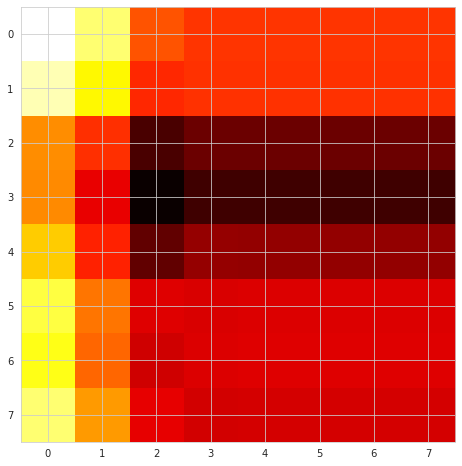

In [15]:
cv_score_df = pd.read_csv("cv_score.csv", header=None)

plt.figure(figsize=(15,8))
plt.imshow(cv_score_df, cmap='hot', interpolation='nearest')
plt.show()

Above chart tells that:  
Number of estimators: 10, number of max_leafs: 9, average CV score: 0.9081813155601779  

is the lowest error estimation

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80, 6120) (80,)
(20, 6120) (20,)


In [19]:
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

forest_reg = RandomForestRegressor(n_estimators=10, max_leaf_nodes=9, n_jobs=-1)
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=5,
                                n_jobs=-1)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [1.2380219  0.99684299 1.14465161 0.7841042  1.24895378]
Mean: 1.0825148963298186
Standard deviation: 0.1744327505897245


Root mean squared error: 0.8755365881793626
Slope: 0.9985328561431255
Intercept: 0.0208778948944213

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              2859.
Date:                Thu, 26 Sep 2019   Prob (F-statistic):                    3.51e-22
Time:                        01:33:31   Log-Likelihood:                         -25.651
No. Observations:                  20   AIC:                                      53.30
Df Residuals:                      19   BIC:                                      54.30
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 co

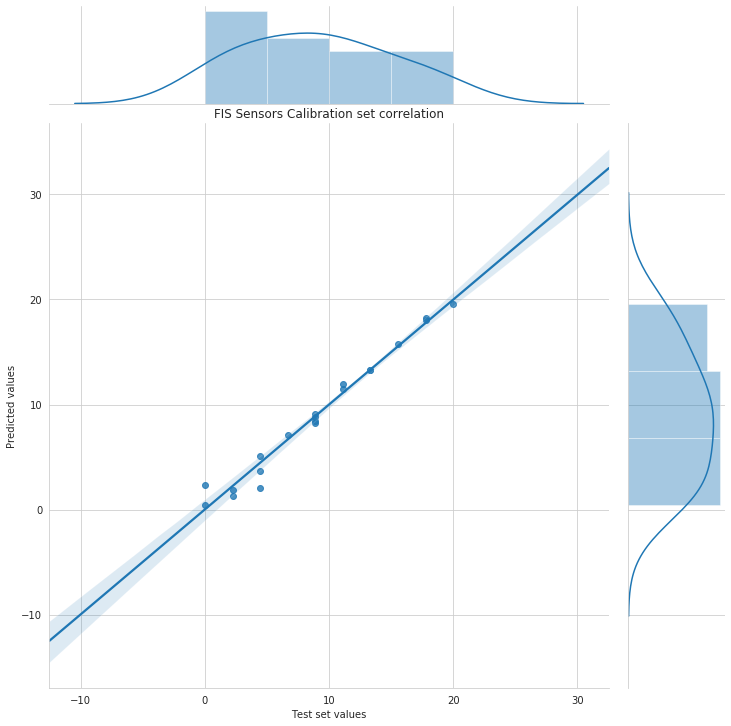

In [20]:
forest_reg.fit(X_train, y_train)

Y_pred = forest_reg.predict(X_test)

forest_mse = mean_squared_error(y_test, Y_pred)
forest_rmse = np.sqrt(forest_mse)
p, residuals, rank, singular_values, rcond = np.polyfit(y_test,Y_pred, 1, full=True)
results = sm.OLS(y_test,Y_pred).fit()
print('Root mean squared error: ' + str(forest_rmse))
print("Slope: " + str(p[0]) + "\nIntercept: " + str(p[1]))
print("")
print(results.summary())

# Correlation plot
sns.jointplot(y_test, Y_pred, kind='reg', height=10)
plt.title("FIS Sensors Calibration set correlation")
plt.ylabel("Predicted values")
plt.xlabel("Test set values")
plt.show()

Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Root mean squared error: 1.3826506029227146
Slope: 0.975154071263845
Intercept: -0.8285108251338021

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.264e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):                   3.03e-106
Time:                        01:37:36   Log-Likelihood:                         -138.02
No. Observations:                 100   AIC:                                      278.0
Df Residuals:                      99   BIC:                                      280.6
Df Model:                           1                                                  
Covariance Type:   

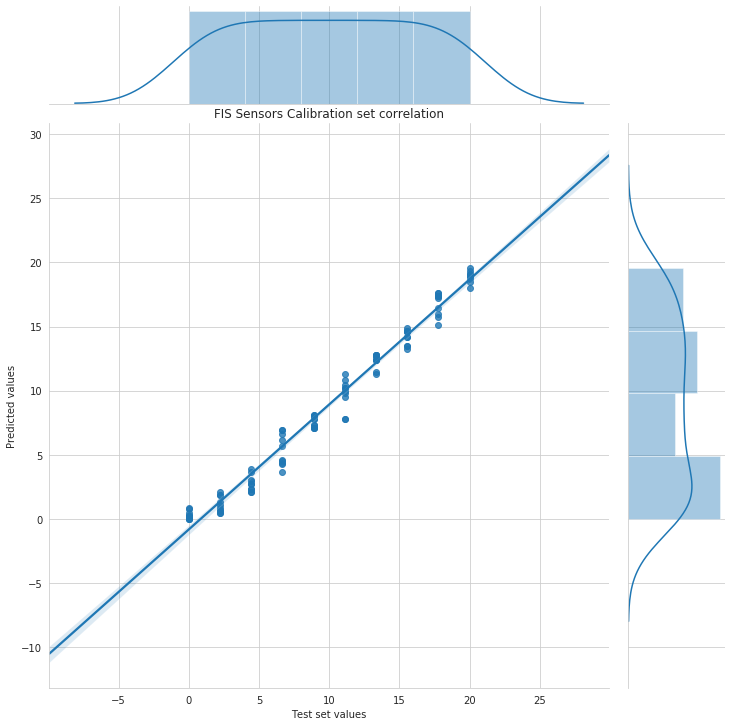

In [23]:
day = 13

val_features_matrix = features_sets[day-1]
val_co_cons = target_sets[day-1]

X, y = sensordata.postprocess_data(val_features_matrix, val_co_cons)

n = len(X)
Y_pred = np.array(forest_reg.predict(X)).reshape(n)
y_eval = np.array(y).reshape(n)

rmse = np.sqrt(mean_squared_error(y_eval, Y_pred))
p, residuals, rank, singular_values, rcond = np.polyfit(y_eval,Y_pred, 1, full=True)
results = sm.OLS(Y_pred,y_eval).fit()
print('Root mean squared error: ' + str(rmse))
print("Slope: " + str(p[0]) + "\nIntercept: " + str(p[1]))
print("")
print(results.summary())

# Correlation plot
sns.jointplot(y_eval,Y_pred, kind='reg', height=10)
plt.title("FIS Sensors Calibration set correlation")
plt.ylabel("Predicted values")
plt.xlabel("Test set values")
plt.savefig('images/val_corr.png',dpi=100)
plt.show()

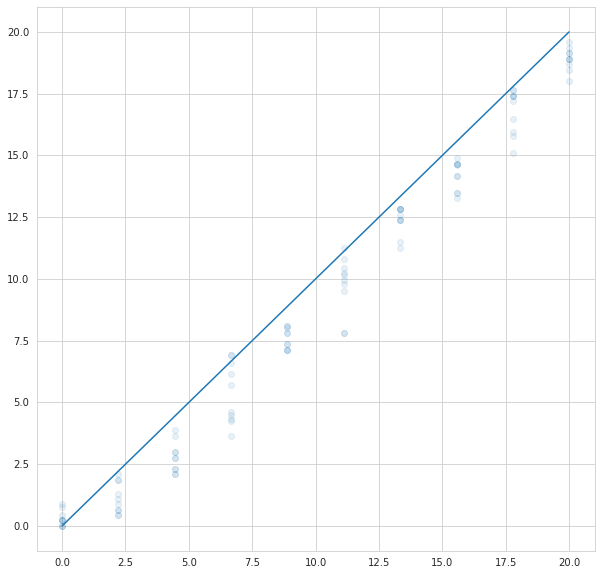

In [24]:
x = y_eval
y = Y_pred.reshape(len(Y_pred))
plt.figure(figsize=(10,10))
plt.scatter(x,y,alpha=0.1)
plt.plot(np.arange(0,21),np.arange(0,21))
plt.show()

Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Postprocessing data matrix into 

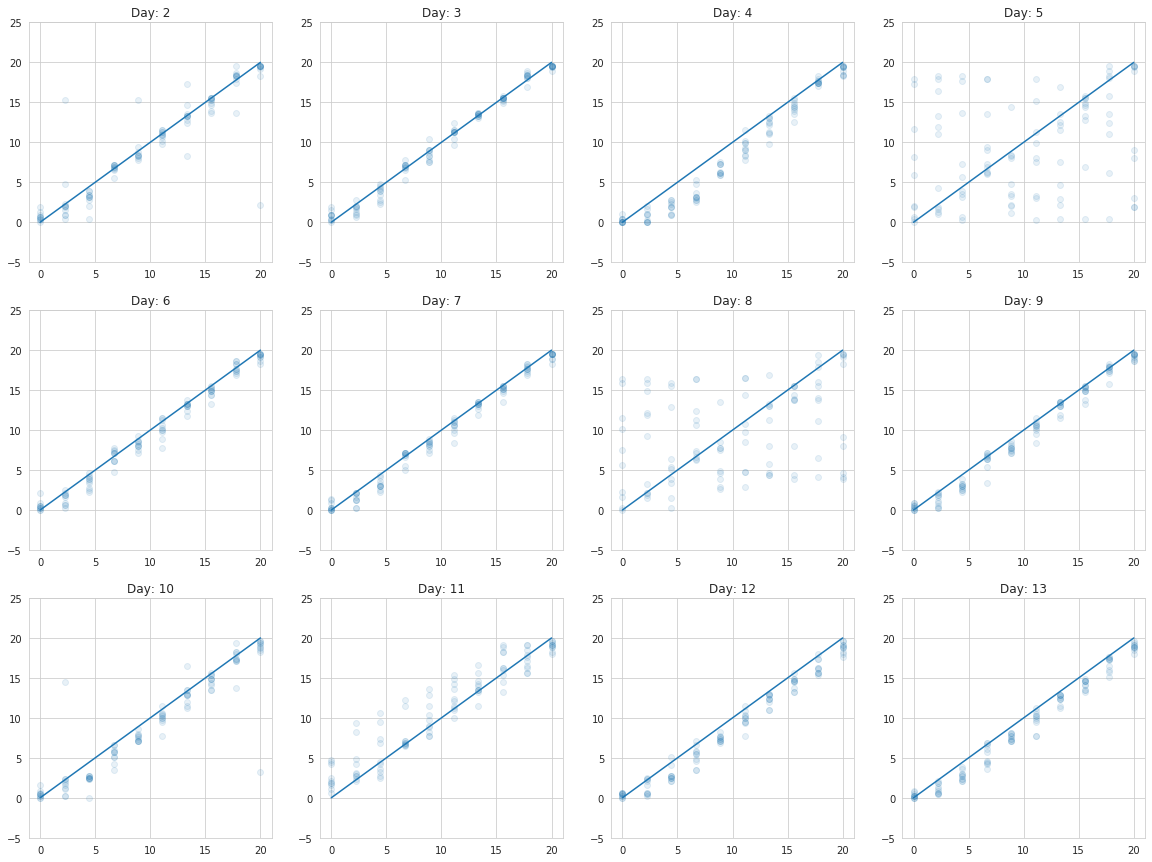

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

fig, axes = plt.subplots(3,4, figsize=(20,15))
row = 0
slopes, intercepts, MSE, r2 = [],[],[],[]
for i in range(1,13):
    val_features_matrix = features_sets[i]
    val_co_cons = target_sets[i]

    X, y = sensordata.postprocess_data(val_features_matrix, val_co_cons)
    n = len(X)
    Y_pred = np.array(forest_reg.predict(X)).reshape(n)
    y_eval = np.array(y).reshape(n)

    x = y_eval.reshape(len(y_eval))
    y = Y_pred.reshape(len(Y_pred))
    p = np.polyfit(x, y, 1)
    slopes.append(p[0])
    intercepts.append(p[1])
    MSE.append(mean_squared_error(x,y))
    r2.append(r2_score(x,y))
    
    col = (i-1)%4
    axes[row,col].scatter(x,y,alpha=0.1)
    axes[row,col].plot(np.arange(0,21),np.arange(0,21))
    axes[row,col].set_title("Day: " + str(i+1))
    axes[row,col].set_ylim((-5,25))
    if i%4 == 0 and i != 0:
        row+=1

plt.show()

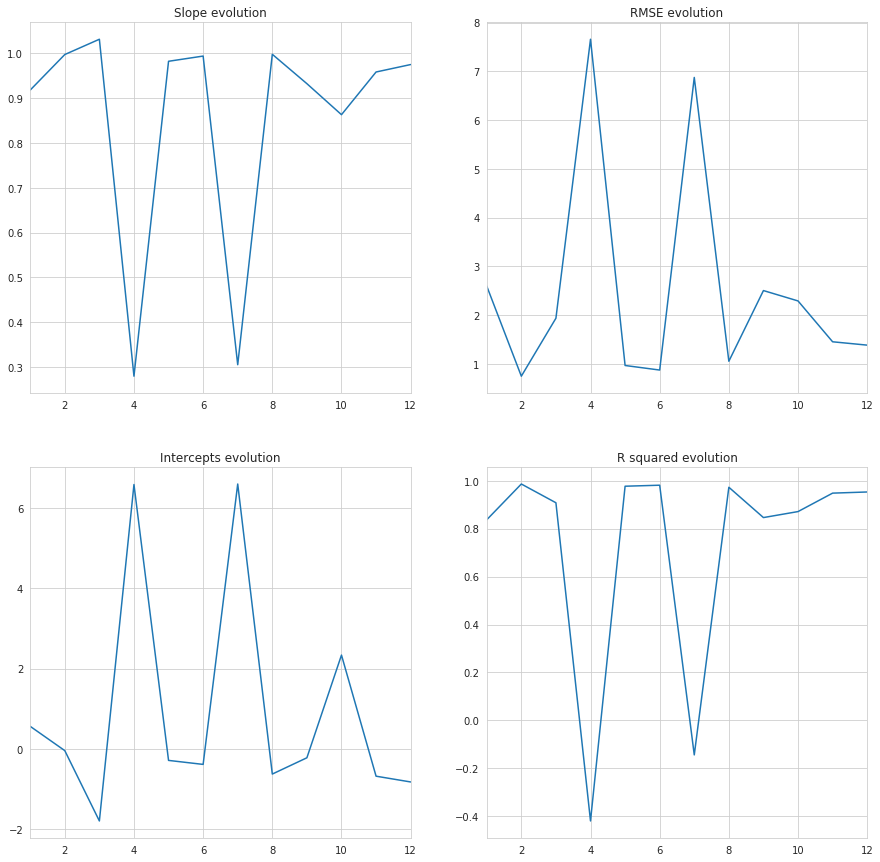

In [26]:
fig, axes = plt.subplots(2,2, figsize = (15,15))
plotrange = np.arange(1,13)

axes[0,0].plot(plotrange,slopes)
axes[0,0].set_title("Slope evolution")
axes[0,0].set_xlim((1,12))

axes[1,0].plot(plotrange,intercepts)
axes[1,0].set_title("Intercepts evolution")
axes[1,0].set_xlim((1,12))

axes[0,1].plot(plotrange,np.sqrt(MSE))
axes[0,1].set_title("RMSE evolution")
axes[0,1].set_xlim((1,12))

axes[1,1].plot(plotrange,r2)
axes[1,1].set_title("R squared evolution")
axes[1,1].set_xlim((1,12))

plt.show()